## SSAC - Exploration 4 - Sentiment Analysis : Naver Movie Review

In [390]:
# impore required packages
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re, os, gensim, random
from konlpy.tag import Okt
from konlpy.tag import Mecab
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [422]:
# load data
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

print(train_data.shape, test_data.shape)
train_data.head()

(150000, 3) (50000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [423]:
# stopwords
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','더이다','으실','.','을려고',
             '으로','자','에','와','한','하다','흠','아','들이','랍니다','세용','습니까','%','30']

In [424]:
# load morphological analyzer Mecab
tokenizer = Mecab()

In [425]:
vocab_size = 10000 # number of words

def load_data(train_data, test_data, num_words=vocab_size):

    train_data.drop_duplicates(subset=['document'], inplace=True) # remove duplicated review data
    train_data = train_data.dropna(how = 'any')  # remove 'NA'
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # tokenize using morphological analyzer
        temp_X = [word for word in temp_X if not word in stopwords] # remove stopwords
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # tokenize
        temp_X = [word for word in temp_X if not word in stopwords] # remove stopwords
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(vocab_size-4) # select most commonly used words 
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [426]:
temp = list(word_to_index.keys())

In [427]:
random.sample(temp, 12)

['감미',
 '라이더',
 '멈출',
 '~~~!!',
 '반응',
 'naver',
 '무겁',
 '만하다',
 '다더니',
 '브라보',
 '돌파',
 '리얼리즘']

## preprocess data

In [428]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [429]:
# define preprocess functions

# convert words in sentence to index
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# take list of sentences and return index list vector 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# decode encoded sentence 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# decode encoded sentences 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [430]:
# check functions
print(X_train[33])
print(get_decoded_sentence(X_train[33], index_to_word))
print('라벨: ', y_train[33])

[63, 370, 130, 38, 58, 53, 9418, 131, 9418, 131, 68]
라도 기대 했 던 내 죄인 입니다 죄인 입니다 ...
라벨:  0


In [431]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  14.812505439262
문장길이 최대 :  115
문장길이 표준편차 :  12.063286059647814


In [433]:
# define max length of sentences 
max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  44
전체 문장의 0.9521088978647377%가 maxlen 설정값 이내에 포함됩니다. 


In [434]:
# pre-padding
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

## split train dataset : validation and train

In [435]:
print(X_train.shape)
print(X_test.shape)

(146182, 44)
(49157, 44)


In [436]:
# set aside validation dataset
x_val = X_train[:30000]   
y_val = y_train[:30000]

# make the rest train dataset
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(116182, 44)
(116182,)
(30000, 44)
(30000,)


## build model no.1 and train

In [437]:
word_vector_dim = 8

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_56 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
lstm_39 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_106 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 9         
Total params: 80,625
Trainable params: 80,625
Non-trainable params: 0
_________________________________________________________________


In [438]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 1s 6ms/step - loss: 0.5308 - accuracy: 0.7622 - val_loss: 0.3790 - val_accuracy: 0.8401
Epoch 2/10
227/227 [==============================] - 1s 5ms/step - loss: 0.3509 - accuracy: 0.8527 - val_loss: 0.3501 - val_accuracy: 0.8488
Epoch 3/10
227/227 [==============================] - 1s 5ms/step - loss: 0.3239 - accuracy: 0.8665 - val_loss: 0.3539 - val_accuracy: 0.8483
Epoch 4/10
227/227 [==============================] - 1s 5ms/step - loss: 0.3127 - accuracy: 0.8726 - val_loss: 0.3523 - val_accuracy: 0.8492
Epoch 5/10
227/227 [==============================] - 1s 5ms/step - loss: 0.3057 - accuracy: 0.8754 - val_loss: 0.3521 - val_accuracy: 0.8497
Epoch 6/10
227/227 [==============================] - 1s 5ms/step - loss: 0.3014 - accuracy: 0.8773 - val_loss: 0.3618 - val_accuracy: 0.8453
Epoch 7/10
227/227 [==============================] - 1s 5ms/step - loss: 0.2965 - accuracy: 0.8804 - val_loss: 0.3546 - val_accuracy: 0.8479
Epoch 

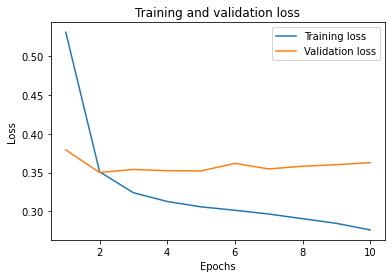

In [439]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

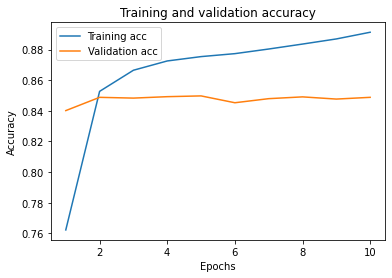

In [440]:
plt.clf()

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

+ validation loss rises after 4 epochs

In [441]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_57 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
lstm_40 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_108 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_109 (Dense)            (None, 1)                 9         
Total params: 80,625
Trainable params: 80,625
Non-trainable params: 0
_________________________________________________________________


In [442]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 4  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
227/227 [==============================] - 1s 7ms/step - loss: 0.5269 - accuracy: 0.7498 - val_loss: 0.3773 - val_accuracy: 0.8398
Epoch 2/4
227/227 [==============================] - 1s 5ms/step - loss: 0.3505 - accuracy: 0.8512 - val_loss: 0.3512 - val_accuracy: 0.8491
Epoch 3/4
227/227 [==============================] - 1s 5ms/step - loss: 0.3242 - accuracy: 0.8650 - val_loss: 0.3461 - val_accuracy: 0.8515
Epoch 4/4
227/227 [==============================] - 1s 5ms/step - loss: 0.3118 - accuracy: 0.8710 - val_loss: 0.3544 - val_accuracy: 0.8467


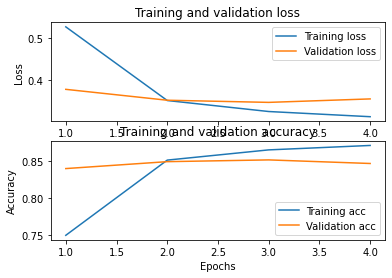

In [443]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [444]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3671 - accuracy: 0.8404
[0.36710816621780396, 0.8403889536857605]


In [445]:
# save trained embedding parameters 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_lstm.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [446]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['기대']
vector

array([ 0.00919157, -0.06900816,  0.00204961,  0.03226217, -0.00467412,
       -0.0305322 ,  0.08016668, -0.04043596], dtype=float32)

In [447]:
word_vectors.similar_by_word("기대")

[('페미니즘', 0.9180502891540527),
 ('헐리우드', 0.9099791049957275),
 ('a', 0.8777371644973755),
 ('미치광이', 0.8691240549087524),
 ('차량', 0.8322340250015259),
 ('동일', 0.8296346664428711),
 ('철학', 0.8289940357208252),
 ('오션스', 0.8219025135040283),
 ('정의', 0.8149250745773315),
 ('이즈', 0.8091405630111694)]

## build model no.2 and train

In [448]:
word_vector_dim = 8

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_58 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
conv1d_57 (Conv1D)           (None, None, 16)          912       
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 16)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_111 (Dense)            (None, 1)               

In [449]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 11s 48ms/step - loss: 0.5759 - accuracy: 0.6855 - val_loss: 0.4601 - val_accuracy: 0.7725
Epoch 2/10
227/227 [==============================] - 1s 4ms/step - loss: 0.4324 - accuracy: 0.7909 - val_loss: 0.4451 - val_accuracy: 0.7795
Epoch 3/10
227/227 [==============================] - 1s 4ms/step - loss: 0.4057 - accuracy: 0.8065 - val_loss: 0.4458 - val_accuracy: 0.7819
Epoch 4/10
227/227 [==============================] - 1s 4ms/step - loss: 0.3885 - accuracy: 0.8162 - val_loss: 0.4488 - val_accuracy: 0.7779
Epoch 5/10
227/227 [==============================] - 1s 4ms/step - loss: 0.3733 - accuracy: 0.8232 - val_loss: 0.4538 - val_accuracy: 0.7792
Epoch 6/10
227/227 [==============================] - 1s 4ms/step - loss: 0.3565 - accuracy: 0.8333 - val_loss: 0.4665 - val_accuracy: 0.7769
Epoch 7/10
227/227 [==============================] - 1s 4ms/step - loss: 0.3380 - accuracy: 0.8432 - val_loss: 0.4776 - val_accuracy: 0.7763
Epoc

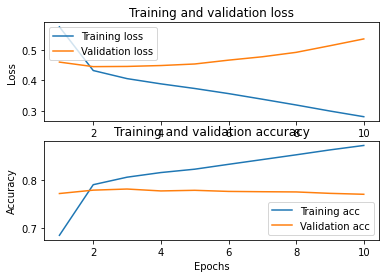

In [450]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [451]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_59 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
conv1d_59 (Conv1D)           (None, None, 16)          912       
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 16)                0         
_________________________________________________________________
dense_112 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_113 (Dense)            (None, 1)               

In [452]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 3

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/3
227/227 [==============================] - 1s 4ms/step - loss: 0.5710 - accuracy: 0.6885 - val_loss: 0.4594 - val_accuracy: 0.7702
Epoch 2/3
227/227 [==============================] - 1s 4ms/step - loss: 0.4307 - accuracy: 0.7912 - val_loss: 0.4426 - val_accuracy: 0.7785
Epoch 3/3
227/227 [==============================] - 1s 4ms/step - loss: 0.4023 - accuracy: 0.8060 - val_loss: 0.4430 - val_accuracy: 0.7801


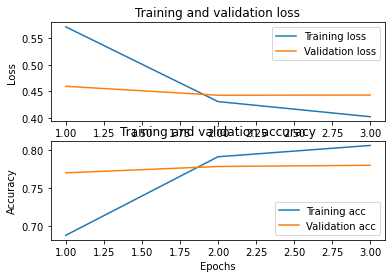

In [453]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [454]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4475 - accuracy: 0.7811
[0.4474853575229645, 0.7810688018798828]


In [455]:
# save trained embedding parameters 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_conv1d.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [456]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['기대']
vector

array([-0.02407505, -0.05762261,  0.08870772, -0.05018235,  0.07563474,
        0.14257954,  0.03100597, -0.03571182], dtype=float32)

In [457]:
word_vectors.similar_by_word("기대")

[('블루', 0.919365406036377),
 ('탱크', 0.9133305549621582),
 ('누워', 0.9120573997497559),
 ('장교', 0.9108635187149048),
 ('통틀어', 0.9102272391319275),
 ('사세요', 0.9086824059486389),
 ('띠', 0.9052791595458984),
 ('완전히', 0.9018454551696777),
 ('햇', 0.8965887427330017),
 ('썰', 0.8914211988449097)]

---

## build model no.3 and train

In [458]:
word_vector_dim = 8   

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_60 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
global_max_pooling1d_18 (Glo (None, 8)                 0         
_________________________________________________________________
dense_114 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_115 (Dense)            (None, 1)                 9         
Total params: 80,081
Trainable params: 80,081
Non-trainable params: 0
_________________________________________________________________


In [459]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10   

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 1s 3ms/step - loss: 0.6196 - accuracy: 0.7213 - val_loss: 0.4952 - val_accuracy: 0.8052
Epoch 2/10
227/227 [==============================] - 1s 3ms/step - loss: 0.4238 - accuracy: 0.8237 - val_loss: 0.3860 - val_accuracy: 0.8306
Epoch 3/10
227/227 [==============================] - 1s 3ms/step - loss: 0.3569 - accuracy: 0.8487 - val_loss: 0.3651 - val_accuracy: 0.8382
Epoch 4/10
227/227 [==============================] - 1s 3ms/step - loss: 0.3270 - accuracy: 0.8627 - val_loss: 0.3609 - val_accuracy: 0.8406
Epoch 5/10
227/227 [==============================] - 1s 3ms/step - loss: 0.3072 - accuracy: 0.8726 - val_loss: 0.3627 - val_accuracy: 0.8399
Epoch 6/10
227/227 [==============================] - 1s 3ms/step - loss: 0.2926 - accuracy: 0.8794 - val_loss: 0.3668 - val_accuracy: 0.8407
Epoch 7/10
227/227 [==============================] - 1s 3ms/step - loss: 0.2806 - accuracy: 0.8843 - val_loss: 0.3735 - val_accuracy: 0.8402
Epoch 

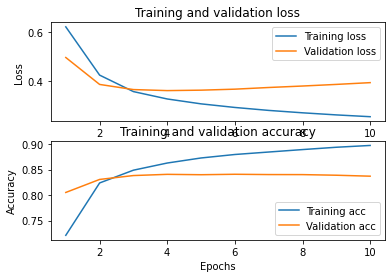

In [460]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

+

In [461]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_61 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
global_max_pooling1d_19 (Glo (None, 8)                 0         
_________________________________________________________________
dense_116 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 9         
Total params: 80,081
Trainable params: 80,081
Non-trainable params: 0
_________________________________________________________________


In [462]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 4  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
227/227 [==============================] - 1s 3ms/step - loss: 0.6179 - accuracy: 0.7357 - val_loss: 0.4842 - val_accuracy: 0.8013
Epoch 2/4
227/227 [==============================] - 1s 4ms/step - loss: 0.4158 - accuracy: 0.8238 - val_loss: 0.3824 - val_accuracy: 0.8320
Epoch 3/4
227/227 [==============================] - 1s 3ms/step - loss: 0.3529 - accuracy: 0.8493 - val_loss: 0.3627 - val_accuracy: 0.8392
Epoch 4/4
227/227 [==============================] - 1s 4ms/step - loss: 0.3234 - accuracy: 0.8634 - val_loss: 0.3582 - val_accuracy: 0.8435


In [463]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 0.3688 - accuracy: 0.8377
[0.3688010573387146, 0.8376629948616028]


+

In [464]:
# save trained embedding parameters
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_maxpool.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 


vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [465]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['기대']
vector

array([-0.12163981, -0.08174503, -0.05736869, -0.05834469, -0.11770461,
       -0.05163111, -0.09976136, -0.06890375], dtype=float32)

In [466]:
word_vectors.similar_by_word("기대")

[('내게', 0.9944955110549927),
 ('주', 0.9935201406478882),
 ('영화', 0.9921828508377075),
 ('어', 0.9920079708099365),
 ('균형', 0.9918190836906433),
 ('해', 0.9900687336921692),
 ('을려고', 0.9897720813751221),
 ('뒤', 0.9896296262741089),
 ('경계', 0.9895750284194946),
 ('준다', 0.9889976382255554)]

## build model no.4 and train

In [469]:
word_vector_dim = 8    

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_64 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
conv1d_63 (Conv1D)           (None, None, 16)          912       
_________________________________________________________________
lstm_43 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_120 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_121 (Dense)            (None, 1)                 9         
Total params: 83,169
Trainable params: 83,169
Non-trainable params: 0
_________________________________________________________________


In [470]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 10

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 1s 6ms/step - loss: 0.4956 - accuracy: 0.7584 - val_loss: 0.3648 - val_accuracy: 0.8419
Epoch 2/10
227/227 [==============================] - 1s 5ms/step - loss: 0.3416 - accuracy: 0.8556 - val_loss: 0.3473 - val_accuracy: 0.8501
Epoch 3/10
227/227 [==============================] - 1s 5ms/step - loss: 0.3187 - accuracy: 0.8658 - val_loss: 0.3459 - val_accuracy: 0.8503
Epoch 4/10
227/227 [==============================] - 1s 5ms/step - loss: 0.3059 - accuracy: 0.8725 - val_loss: 0.3455 - val_accuracy: 0.8495
Epoch 5/10
227/227 [==============================] - 1s 5ms/step - loss: 0.2954 - accuracy: 0.8768 - val_loss: 0.3490 - val_accuracy: 0.8511
Epoch 6/10
227/227 [==============================] - 1s 5ms/step - loss: 0.2840 - accuracy: 0.8836 - val_loss: 0.3482 - val_accuracy: 0.8512
Epoch 7/10
227/227 [==============================] - 1s 5ms/step - loss: 0.2714 - accuracy: 0.8889 - val_loss: 0.3572 - val_accuracy: 0.8487
Epoch 

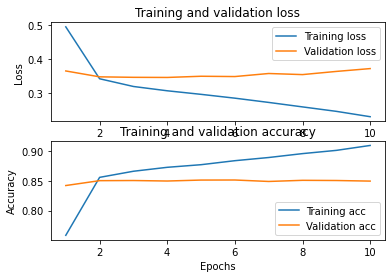

In [471]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

+

In [473]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_66 (Embedding)     (None, None, 8)           80000     
_________________________________________________________________
conv1d_65 (Conv1D)           (None, None, 16)          912       
_________________________________________________________________
lstm_45 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_124 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_125 (Dense)            (None, 1)                 9         
Total params: 83,169
Trainable params: 83,169
Non-trainable params: 0
_________________________________________________________________


In [474]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 4

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
227/227 [==============================] - 1s 6ms/step - loss: 0.5092 - accuracy: 0.7381 - val_loss: 0.3655 - val_accuracy: 0.8424
Epoch 2/4
227/227 [==============================] - 1s 5ms/step - loss: 0.3391 - accuracy: 0.8549 - val_loss: 0.3438 - val_accuracy: 0.8500
Epoch 3/4
227/227 [==============================] - 1s 5ms/step - loss: 0.3117 - accuracy: 0.8678 - val_loss: 0.3476 - val_accuracy: 0.8488
Epoch 4/4
227/227 [==============================] - 1s 5ms/step - loss: 0.2965 - accuracy: 0.8751 - val_loss: 0.3466 - val_accuracy: 0.8496


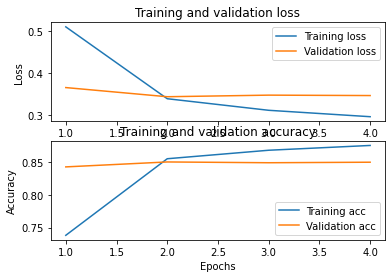

In [475]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [476]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3591 - accuracy: 0.8430
[0.3591158390045166, 0.8429521918296814]


In [477]:
# save trained embedding parameters
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_conv1d_lstm.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 


vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [478]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['기대']
vector

array([ 0.04258498,  0.01680124,  0.04701795, -0.07941996,  0.02101266,
        0.03413212,  0.03972927, -0.05918861], dtype=float32)

In [479]:
word_vectors.similar_by_word("기대")

[('제공', 0.9372509717941284),
 ('혼신', 0.8636711835861206),
 ('듬뿍', 0.836202085018158),
 ('건데', 0.8267544507980347),
 ('고서', 0.8042954206466675),
 ('인간미', 0.7882776856422424),
 ('라길래', 0.7839807271957397),
 ('져야', 0.7740871906280518),
 ('안쓰럽', 0.7733958959579468),
 ('격투기', 0.7720723748207092)]

---

## use pre-trained word2vec embedding to improve model performance

In [480]:
path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.bin'
trained_w2v = gensim.models.Word2Vec.load(path)

In [482]:
similar_vec = trained_w2v.wv.most_similar("기대")
similar_vec

[('예상', 0.5993404388427734),
 ('예측', 0.5521305203437805),
 ('전망', 0.5395902395248413),
 ('걱정', 0.5109213590621948),
 ('우려', 0.5100494623184204),
 ('생각', 0.5072912573814392),
 ('평가', 0.5036546587944031),
 ('신뢰', 0.5025410652160645),
 ('희망', 0.49611741304397583),
 ('관심도', 0.4947463572025299)]

In [483]:
type(trained_w2v)

gensim.models.word2vec.Word2Vec

In [484]:
type(word_vectors)

gensim.models.keyedvectors.Word2VecKeyedVectors

In [485]:
trained_word_vectors = trained_w2v.wv

In [486]:
type(trained_word_vectors)

gensim.models.keyedvectors.Word2VecKeyedVectors

In [487]:
vector = trained_word_vectors['기대']
print(vector.shape)
vector

(200,)


array([-0.42679408,  0.5892111 ,  0.6219986 , -2.321125  , -1.4077828 ,
        2.0710788 , -1.202137  , -0.11560407, -1.9535756 , -0.33151925,
       -0.94134295, -1.3920565 , -0.673567  , -0.7687422 ,  0.7271645 ,
       -0.8008593 , -0.43518832, -0.9391257 , -1.9923116 , -0.4860049 ,
        2.0586452 ,  0.08421105, -0.86913145,  1.288601  ,  1.433492  ,
        1.2044291 , -0.54404306, -1.5097954 , -0.52747834, -0.74069464,
       -1.4989316 ,  0.70926476, -1.7328253 , -1.3000728 ,  0.810795  ,
       -0.6369874 ,  1.7686176 , -0.6763047 , -0.5367612 ,  2.4611883 ,
        1.4960446 , -0.1725292 , -0.45655453,  0.2681983 ,  0.3066007 ,
        0.30748022,  2.2485256 , -0.8582102 ,  0.39929923,  0.00466653,
        0.3073698 ,  0.85514444, -0.5583773 ,  1.4897436 , -0.805984  ,
       -0.7717855 ,  1.499113  , -0.51766735, -0.5974332 ,  0.85677636,
       -0.74764436,  2.067837  , -0.740197  ,  0.29757446, -1.7932417 ,
        0.57957464,  0.05866075,  1.2170862 ,  1.7554603 ,  0.86

In [488]:
trained_word_vectors.similar_by_word("기대")

[('예상', 0.5993404388427734),
 ('예측', 0.5521305203437805),
 ('전망', 0.5395902395248413),
 ('걱정', 0.5109213590621948),
 ('우려', 0.5100494623184204),
 ('생각', 0.5072912573814392),
 ('평가', 0.5036546587944031),
 ('신뢰', 0.5025410652160645),
 ('희망', 0.49611741304397583),
 ('관심도', 0.4947463572025299)]

In [489]:
vocab_size = 10000    
word_vector_dim = 200  

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# copy pretrained embedding to embedding_matrix
for i in range(4,vocab_size):
    if index_to_word[i] in trained_word_vectors:
        embedding_matrix[i] = trained_word_vectors[index_to_word[i]]

In [490]:
embedding_matrix.shape

(10000, 200)

In [491]:
from tensorflow.keras.initializers import Constant

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))   
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_67 (Embedding)     (None, 44, 200)           2000000   
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 38, 16)            22416     
_________________________________________________________________
lstm_46 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_126 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_127 (Dense)            (None, 1)                 9         
Total params: 2,024,673
Trainable params: 2,024,673
Non-trainable params: 0
_________________________________________________________________


In [492]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 15 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
227/227 [==============================] - 12s 51ms/step - loss: 0.5146 - accuracy: 0.7418 - val_loss: 0.4129 - val_accuracy: 0.8134
Epoch 2/15
227/227 [==============================] - 6s 27ms/step - loss: 0.3702 - accuracy: 0.8391 - val_loss: 0.3613 - val_accuracy: 0.8423
Epoch 3/15
227/227 [==============================] - 6s 27ms/step - loss: 0.3178 - accuracy: 0.8659 - val_loss: 0.3428 - val_accuracy: 0.8514
Epoch 4/15
227/227 [==============================] - 6s 27ms/step - loss: 0.2861 - accuracy: 0.8829 - val_loss: 0.3418 - val_accuracy: 0.8537
Epoch 5/15
227/227 [==============================] - 6s 27ms/step - loss: 0.2611 - accuracy: 0.8952 - val_loss: 0.3465 - val_accuracy: 0.8538
Epoch 6/15
227/227 [==============================] - 6s 28ms/step - loss: 0.2410 - accuracy: 0.9043 - val_loss: 0.3504 - val_accuracy: 0.8553
Epoch 7/15
227/227 [==============================] - 6s 27ms/step - loss: 0.2213 - accuracy: 0.9138 - val_loss: 0.3648 - val_accuracy: 0.852

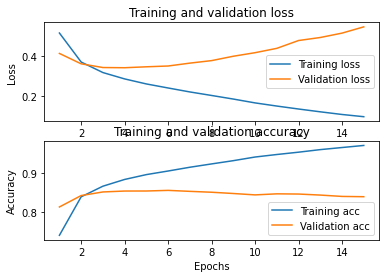

In [493]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [495]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))   
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_69 (Embedding)     (None, 44, 200)           2000000   
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 38, 16)            22416     
_________________________________________________________________
lstm_48 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_130 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 9         
Total params: 2,024,673
Trainable params: 2,024,673
Non-trainable params: 0
_________________________________________________________________


In [496]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
227/227 [==============================] - 6s 28ms/step - loss: 0.5255 - accuracy: 0.7408 - val_loss: 0.4187 - val_accuracy: 0.8162
Epoch 2/5
227/227 [==============================] - 6s 27ms/step - loss: 0.3734 - accuracy: 0.8382 - val_loss: 0.3600 - val_accuracy: 0.8420
Epoch 3/5
227/227 [==============================] - 6s 27ms/step - loss: 0.3185 - accuracy: 0.8665 - val_loss: 0.3404 - val_accuracy: 0.8498
Epoch 4/5
227/227 [==============================] - 6s 27ms/step - loss: 0.2866 - accuracy: 0.8819 - val_loss: 0.3366 - val_accuracy: 0.8547
Epoch 5/5
227/227 [==============================] - 6s 27ms/step - loss: 0.2613 - accuracy: 0.8945 - val_loss: 0.3421 - val_accuracy: 0.8532


In [497]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3543 - accuracy: 0.8509
[0.3542567193508148, 0.8508656024932861]


---